<a href="https://colab.research.google.com/github/AbrahamAzizi/ModelBasedCompressiveSensing/blob/main/WaveletBasis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The acquisition device like ADC approximates the signal with a sampling rate in time and resolution in magnitude. If we consider $\{2^m t-n_{wavelet}\} \rightarrow \{n_{sampling}\}$, the disceret signal represents on highes possible resolution m of device sampling rate:<br>
$$
x(t) = \sum{x_{m,n} 2^{\frac{m}{2}} \phi(2^{m} t - n)}
$$
$x_{m,n}$ is a signal projection on the highest sampling rate and resolution of ADC. Therefore, the discrete signal already represents on highest possible wavelet representation. The DWT transforms the highest resolution into the lowest.<br>
Here, we are working with haar wavelets at level e. For other wavelets and higher decomposition levels, a modification on DWT matrices is required.

In [ ]:
import matplotlib.pyplot as plt
size=15
parameters = {'axes.labelsize': size, 'axes.titlesize': size, 'figure.titlesize': size,
              'xtick.labelsize': size, 'ytick.labelsize': size, 'legend.fontsize': 15,
              'legend.title_fontsize': 15, 'figure.figsize':(16,4)}
plt.rcParams.update(parameters)
import seaborn as sns
import numpy as np
import seaborn as sn
import h5py
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, Lars
from scipy.fftpack import dct, idct, fft
from scipy import linalg
from scipy import signal
import pywt
from skimage.metrics import structural_similarity as SSIM
import os
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
#given a liest of numpy array v 
def make_gif(v, input_shape):
#    plt.rcParams['figure.figsize'] = [8,6]
    r,c=input_shape
    plt.rc('animation', html='html5')
    fig = plt.figure(figsize=(6,4))
    s = abs(v[0].reshape(r,c))
    im = plt.imshow(s, animated=True)

    def updatefig(i):
        im.set_array(abs(v[i].reshape(r,c)))
        return im,
    anim = animation.FuncAnimation(fig, updatefig,
                                   frames=len(v),interval=200,
                                   blit=True)
#    HTML(anim.to_html5_video())
    plt.close()
    return anim
#     writervideo = animation.FFMpegWriter(fps=4)
#     anim.save(str(name)+'.gif', writer=writervideo)
#     plt.close()

def rip(k1, delta, l, k):  
    #k_star
    k_star = 2/(1-np.log(2))
    # k2
    k2 = delta**2 / (2*k_star) - 1 / (k1*np.log(42*np.e / delta))
    # number of measurements
    nm = int( round(k1*k*np.log(l/k) ) )
    # probability of RIP satisfaction
    p = 1 - 2*np.exp(k2*nm)
    return nm, p

def make_sparse(x,t):
    l = x.reshape(-1)
    p = np.argsort(np.abs(l))[-t]
    s = np.ma.masked_where(np.abs(x) < np.abs(l[p]), x)
    y = np.ma.filled(s.astype(float), 0.0)
    return y

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = np.max(original)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# mirror padding the image
# input: image, length of low and high pass filters
# output: mirror padding the image
def img_pad(img,len_dl,len_dh):
    pad_bgn=img[:,:len_dl][:,::-1]
    pad_end=img[:,::-1][:,:len_dl]
    imgv=np.hstack((pad_bgn,img,pad_end))
    pad_up=imgv[:len_dh,:][::-1,:]
    pad_dwn=imgv[::-1,:][:len_dh,:]
    return np.vstack((pad_up,imgv,pad_dwn))

def img_dpad(imgp, len_dl,len_dh):
  return imgp[len_dl:-len_dl , len_dh:-len_dh]



# in hl and lh the left side applied on raws and right side on columns as Y=AXB^T
# so, the position of lh means raw_h and column_l hence, klh=k_01=kron(kh, kl)
# input: padded image shape, low and high pass filters
# output: kernels of ll, lh, hl and hh
def dwt2d_M(imgp_shape, lowf, highf):
    r,c= imgp_shape
    kl= np.kron(np.eye(r//2), lowf)
    kh= np.kron(np.eye(c//2), highf)
    kll= np.kron(kl, kl)
    klh= np.kron(kh, kl)
    khl= np.kron(kl, kh)
    khh= np.kron(kh, kh)
    return kll, klh, khl, khh

def soft_thresh(x, l1):
    return np.sign(x) * np.maximum(np.abs(x) - l1, 0.)

def fist(A, y, l1, maxit):
    x = np.zeros(A.shape[1])
    t = 1
    z = x.copy()
    L = linalg.norm(A, ord=2) **2
    for _ in range(maxit):
        xold = x.copy()
        r= y - A.dot(z)
        z = z + np.dot(A.T, r) / L
        x = soft_thresh(z, l1 / L)
        t0 = t
        t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
    return x

def amp(A, y, l1, maxit):
    x= np.zeros(A.shape[1])
    z= y
    for _ in range(maxit):
        theta = l1 * np.sqrt(linalg.norm(z)**2/len(y)) # alpha*tau
        s= x + np.dot(A.T,z)
        x= soft_thresh(s, theta)
        # update with osenger
        b= linalg.norm(x,0)/len(y)
        z= y - np.dot(A,x) + b*z
    return x

### reade data and build dataset:

In [ ]:
## use this class when we want to process the whole data with tf pipline 
#import tensorflow as tf

#path = 'data/MEA10*10/recgen_cell_10/0.h5'
#path = 'data/MEA100*100/recgen.h5'
# class generator:
#     def __init__(self, file):
#         self.file = file

#     def __call__(self):
#         with h5py.File(self.file, 'r') as hf:
#             for im in hf['recordings']:
#                 yield im
                
# nex, ney= 100, 100
# ds = tf.data.Dataset.from_generator(generator(path),
#                                     output_types=(tf.float32),
#                                     output_shapes=(nex*ney,))
# ds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/Thesis/Codes/data'
dir = os.path.join(path,'100_RecordingFrames(f30tof130).npy')
with open(dir, 'rb') as f:
  rec= np.load(f)

nex=100
ney=100
l=nex*ney
t=30
v = rec[:t,:]

In [ ]:
make_gif(v.reshape((t,nex,ney)), (nex,ney))

### With 1% of coefficients on F space we have a better sorting result

In [ ]:
vr=np.zeros(v.shape)
for i,x in enumerate(v):
    vr[i,:]= idct(make_sparse(dct(x,norm='ortho'), l//100),norm='ortho')

In [ ]:
ps=[]
for i in range(t):
  ps.append(PSNR(v[i],vr[i]))
psnr={'sparse':ps}

In [ ]:
ss=[]
for i in range(t):
  ss.append(SSIM(v[i],vr[i]))
ssim={'sparse':ss}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until


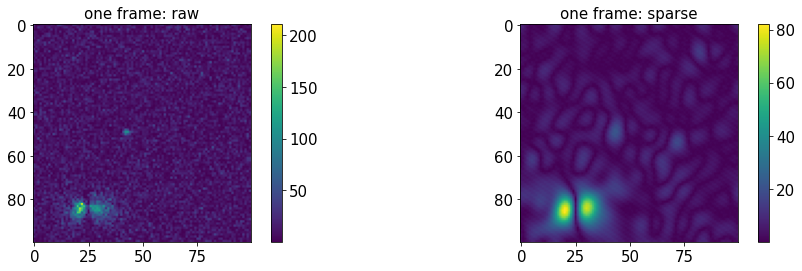

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw')
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: sparse')
plt.colorbar()

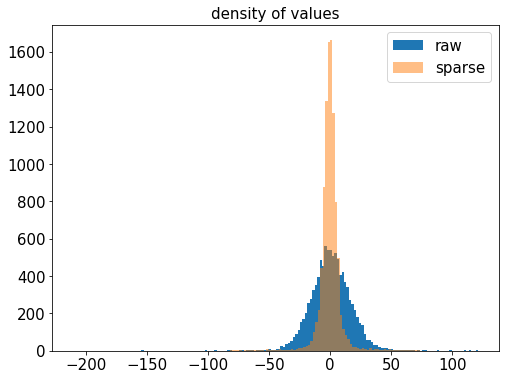

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

In [ ]:
make_gif(vr.reshape((t,nex,ney)), (nex,ney))

### test the matrix implementation of wavelet transform 

In [ ]:
wavelet = pywt.Wavelet('haar')
wavelet

pywt._extensions._pywt.Wavelet(name='haar', filter_bank=([0.7071067811865476, 0.7071067811865476], [-0.7071067811865476, 0.7071067811865476], [0.7071067811865476, 0.7071067811865476], [0.7071067811865476, -0.7071067811865476]))

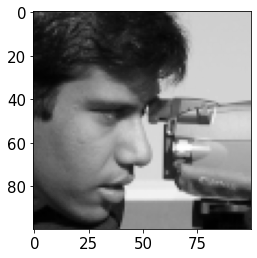

In [ ]:
#img=v[5].reshape(nex,ney)
img=pywt.data.camera().astype(np.float32)[100:200,200:300]
plt.imshow(img, cmap=plt.cm.gray)

In [ ]:
# read filters
dl=np.array([1/np.sqrt(2), 1/np.sqrt(2)])
dh=np.array([1/np.sqrt(2), -1/np.sqrt(2)])
rl=dl
rh=-dh

# mirror pad image
imgp= img_pad(img, len(dl), len(dh))

# build kernels
kll, klh, khl, khh= dwt2d_M(imgp.shape, dl, dh)

In [ ]:
r,c= (nex+len(dl)+len(dh))//2, (ney+len(dl)+len(dh))//2
ll=kll.dot(imgp.reshape(-1)).reshape(r,c)
lh=klh.dot(imgp.reshape(-1)).reshape(r,c)
hl=khl.dot(imgp.reshape(-1)).reshape(r,c)
hh=khh.dot(imgp.reshape(-1)).reshape(r,c)

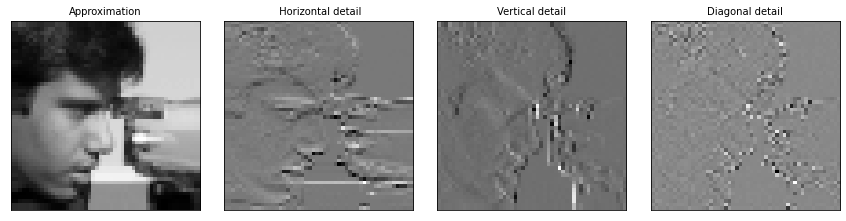

In [ ]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([ll, lh, hl, hh]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

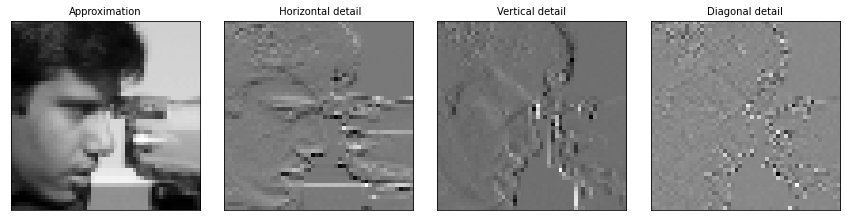

In [ ]:
# implementation with pywt package

titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

LL, (LH, HL, HH)= pywt.dwt2(img, 'haar')
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest",cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

### l1 regularization in wavelet space

In [ ]:
# read filters
dl=np.array([1/np.sqrt(2), 1/np.sqrt(2)])
dh=np.array([1/np.sqrt(2), -1/np.sqrt(2)])
rl=dl
rh=-dh

# mirror pad image
imgp= img_pad(v[5].reshape(nex,ney), len(dl), len(dh))

# build kernels
kll, klh, khl, khh= dwt2d_M(imgp.shape, dl, dh)

In [ ]:
k1=1
delta= .9
l= nex*ney
k= l//20
nm, p= rip(k1, delta, l, k)

print('number of measurements= %s (%s %%)'%(nm, 100*nm/l))
print('RIP probability= ', p)

number of measurements= 1498 (14.98 %)
RIP probability=  1.0


In [ ]:
l= imgp.shape[0]*imgp.shape[1]
Mg= np.random.normal(0.0, 1/np.sqrt(nm), (nm, l))
Mb= np.random.binomial(1, .15, size=(nm,l))
Mi= np.diag(np.random.binomial(1, .5, size=(l,)))
M=Mi
All= np.dot(M, kll.T)
Alh= np.dot(M, klh.T)
Ahl= np.dot(M, khl.T)
Ahh= np.dot(M, khh.T)

In [ ]:
l1 = 10  # regularization parameter
maxit = 100
y= np.dot(M, imgp.reshape(-1))
zll= fist(All, y, l1, maxit)
zlh= fist(Alh, y, l1, maxit)
zhl= fist(Ahl, y, l1, maxit)
zhh= fist(Ahh, y, l1, maxit)

In [ ]:
r,c= imgp.shape
ll= zll.reshape(r//2,c//2)
lh= zhl.reshape(r//2,c//2)
hl= zlh.reshape(r//2,c//2)
hh= zhh.reshape(r//2,c//2)

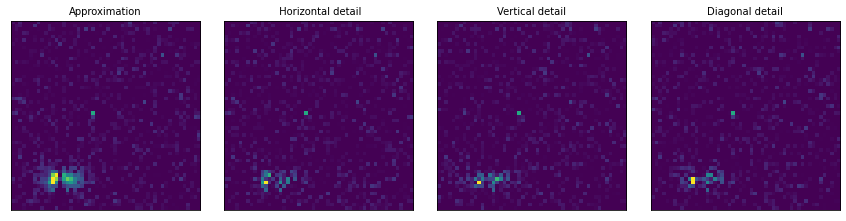

In [ ]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([ll, lh, hl, hh]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(abs(a), interpolation="nearest")
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

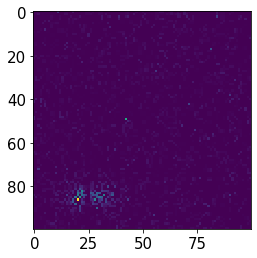

In [ ]:
# recornstruction without diagonal details
# a depadding is required
tmp=kll.T.dot(zll.reshape(-1))+klh.T.dot(zlh.reshape(-1))+khl.T.dot(zhl.reshape(-1))+khh.T.dot(zhh.reshape(-1))
vr=tmp.reshape(imgp.shape)[len(dl):-len(dl),len(dh):-len(dh)]
plt.imshow(abs(vr), interpolation="nearest")

In [ ]:
r=nex+len(dl)+len(dh)
c=ney+len(dl)+len(dh)
vp=np.zeros((v.shape[0],r*c))
for i,x in enumerate(v):
    print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
    tmp= img_pad(x.reshape(nex,ney),len(dl),len(dh))
    vp[i,:]=tmp.reshape(-1)

 frame..........29/29

In [ ]:
l1 = 10  # regularization parameter
maxit = 100
vr=np.zeros(v.shape)
for i,x in enumerate(vp):
    print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
    y= np.dot(M, x.reshape(-1))
    zll= fist(All, y, l1, maxit)
    zlh= fist(Alh, y, l1, maxit)
    zhl= fist(Ahl, y, l1, maxit)
    zhh= fist(Ahh, y, l1, maxit)
    tmp=kll.T.dot(zll.reshape(-1))+klh.T.dot(zlh.reshape(-1))+khl.T.dot(zhl.reshape(-1))+khh.T.dot(zhh.reshape(-1))
    tmp=img_dpad(tmp.reshape(imgp.shape), len(dl), len(dh))
    vr[i,:]= tmp.reshape(-1)

 frame..........29/29

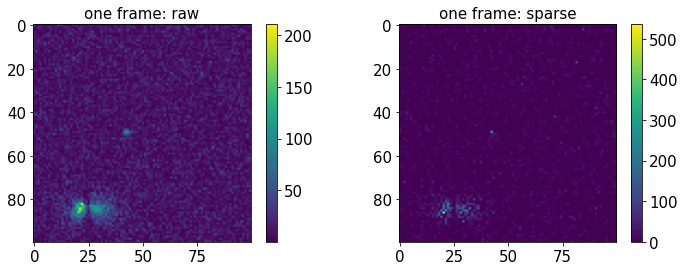

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw')
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: sparse')
plt.colorbar()

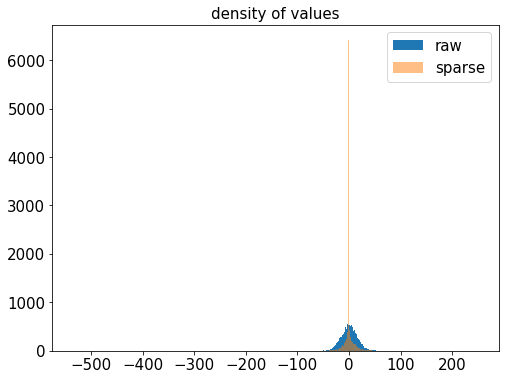

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

<Figure size 576x432 with 0 Axes>

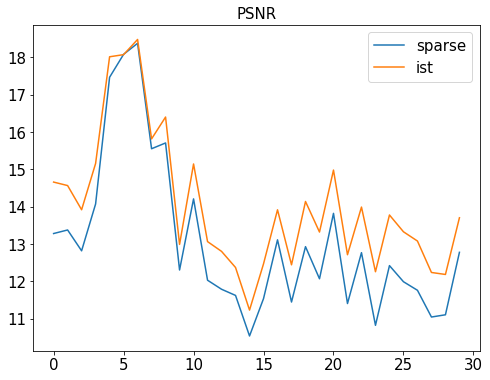

In [ ]:
ps=[]
for i in range(t):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'ist':ps})

plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['ist'], label= 'ist')
plt.title('PSNR')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

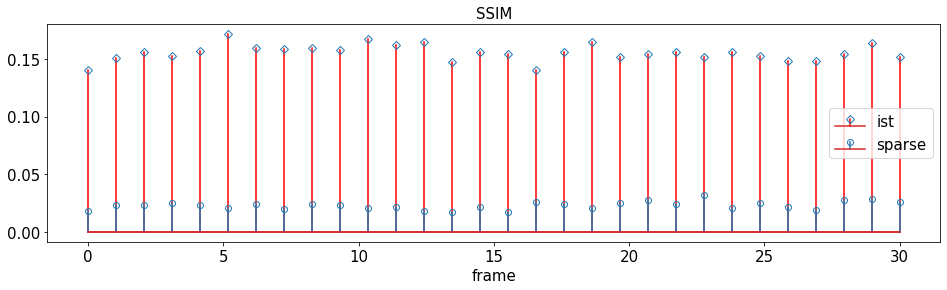

In [ ]:
ss=[]
for i in range(t):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'ist':ss})

x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['ist'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='ist')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
make_gif(vr, (nex,ney))

In [ ]:
l1 = 1  # regularization parameter
maxit = 100
vr=np.zeros(v.shape)
for i,x in enumerate(vp):
    print('\r', 'frame' + "." * 10, end=str(i)+'/'+str(t-1))
    y= np.dot(M, x.reshape(-1))
    zll= amp(All, y, l1, maxit)
    zlh= amp(Alh, y, l1, maxit)
    zhl= amp(Ahl, y, l1, maxit)
    zhh= amp(Ahh, y, l1, maxit)
    tmp=kll.T.dot(zll.reshape(-1))+klh.T.dot(zlh.reshape(-1))+khl.T.dot(zhl.reshape(-1))+khh.T.dot(zhh.reshape(-1))
    tmp=img_dpad(tmp.reshape(imgp.shape), len(dl), len(dh))
    vr[i,:]= tmp.reshape(-1)

 frame..........29/29

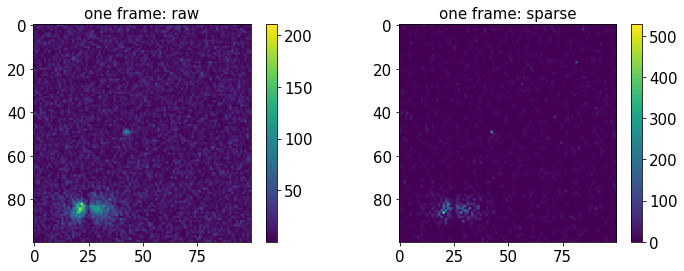

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(abs(v[5].reshape(nex,ney)))
plt.title('one frame: raw')
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(vr[5].reshape(nex,ney)))
plt.title('one frame: sparse')
plt.colorbar()

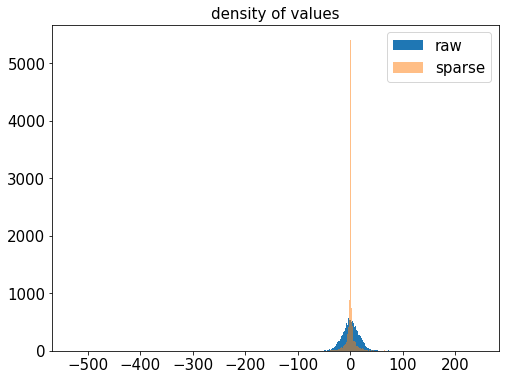

In [ ]:
plt.figure(figsize=(8,6))
HIST_BINS= np.arange(np.min(v[5]), np.max(v[5]), 2)
plt.hist(v[5], HIST_BINS, label='raw')
HIST_BINS= np.arange(np.min(vr[5]), np.max(vr[5]), 2)
plt.hist(vr[5], HIST_BINS, alpha = 0.5,label='sparse')
plt.title('density of values')
plt.legend()

<Figure size 576x432 with 0 Axes>

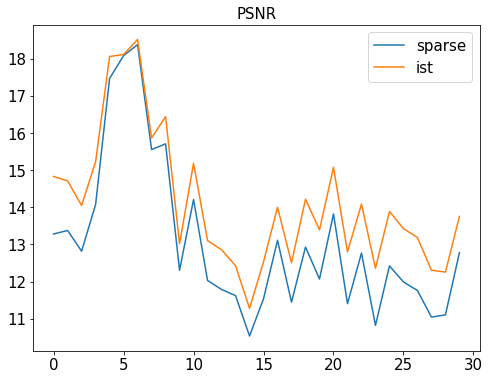

In [ ]:
ps=[]
for i in range(t):
  ps.append(PSNR(v[i],vr[i]))
psnr.update({'ist':ps})

plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
plt.plot(psnr['sparse'], label= 'sparse')
plt.plot(psnr['ist'], label= 'ist')
plt.title('PSNR')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argum

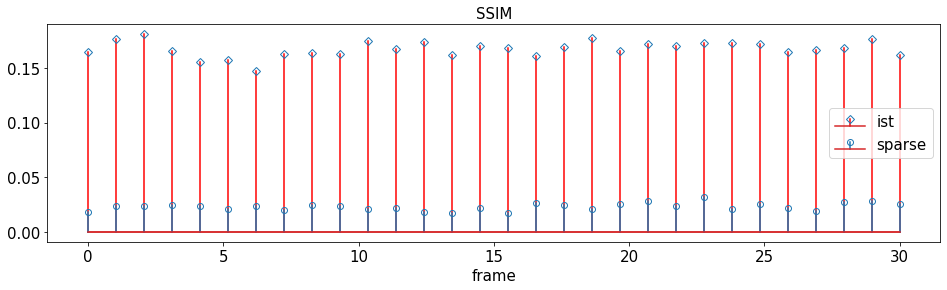

In [ ]:
ss=[]
for i in range(t):
  ss.append(SSIM(v[i],vr[i]))
ssim.update({'ist':ss})

x= x = np.linspace(0, len(v),len(v))
markerline, stemlines, baseline = plt.stem(x, ssim['ist'],
                                           linefmt='red',
                                           markerfmt='D',
                                           bottom=0,
                                           label='ist')
markerline.set_markerfacecolor('None')
markerline, stemlines, baseline = plt.stem(x, ssim['sparse'], label='sparse')
markerline.set_markerfacecolor('None')
plt.xlabel('frame')
plt.title('SSIM')
plt.legend()

In [ ]:
make_gif(vr, (nex,ney))